<a href="https://colab.research.google.com/github/diliprc96/POS_Tagging/blob/main/POS_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/POS_Tagging/DATASET_POS.zip
!unzip /content/drive/MyDrive/POS_Tagging/glove.6B.100d.txt.zip

Archive:  /content/drive/MyDrive/POS_Tagging/DATASET_POS.zip
  inflating: Dataset_POS/WSJ_test.pos  
  inflating: Dataset_POS/WSJ_train.pos  
Archive:  /content/drive/MyDrive/POS_Tagging/glove.6B.100d.txt.zip
  inflating: glove.6B.100d.txt       


In [3]:
# Importing Libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Bidirectional
from transformers import BertTokenizer, TFBertModel
import importlib.util
from tensorflow.keras.callbacks import EarlyStopping

# Check Import Modules
def check_import(module_name):
    if importlib.util.find_spec(module_name) is not None:
        print(f"{module_name} ✅ Imported Successfully")
    else:
        print(f"{module_name} ❌ Not Installed")

modules = ['os', 'numpy', 'pandas', 'matplotlib', 'sklearn', 'tensorflow', 'transformers']
for module in modules:
    check_import(module)

os ✅ Imported Successfully
numpy ✅ Imported Successfully
pandas ✅ Imported Successfully
matplotlib ✅ Imported Successfully
sklearn ✅ Imported Successfully
tensorflow ✅ Imported Successfully
transformers ✅ Imported Successfully


In [4]:
# Load Dataset
def load_data(file_path):
    if not os.path.exists(file_path):
        print(f"File Not Found: {file_path}")
        return None
    sentences, sentence = [], []
    for line in open(file_path, 'r'):
        line = line.strip()
        if line == "":
            if sentence:
                sentences.append(sentence)
                sentence = []
        else:
            try:
                word, tag = line.split()
                sentence.append((word, tag))
            except ValueError:
                continue
    if sentence:
        sentences.append(sentence)
    return sentences

# Dataset Path
dataset_folder = "/content/Dataset_POS"

train_data = load_data(os.path.join(dataset_folder, 'WSJ_train.pos'))
test_data = load_data(os.path.join(dataset_folder, 'WSJ_test.pos'))

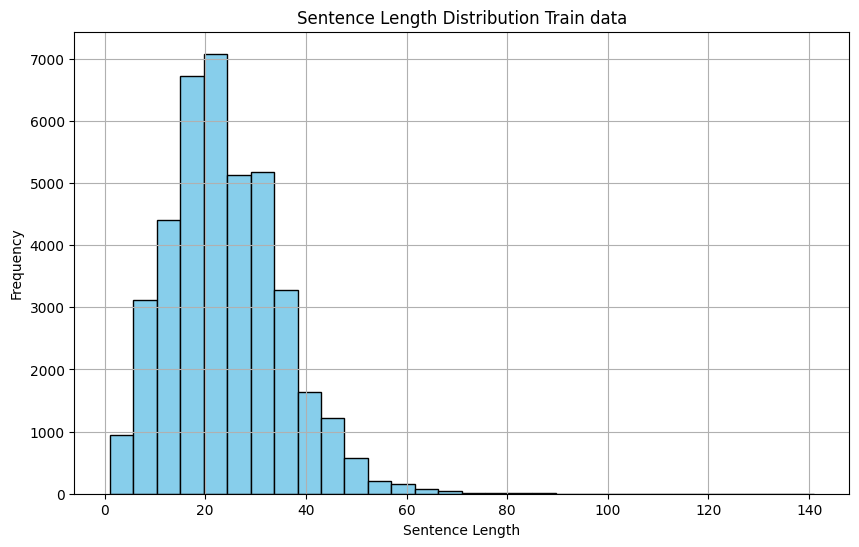

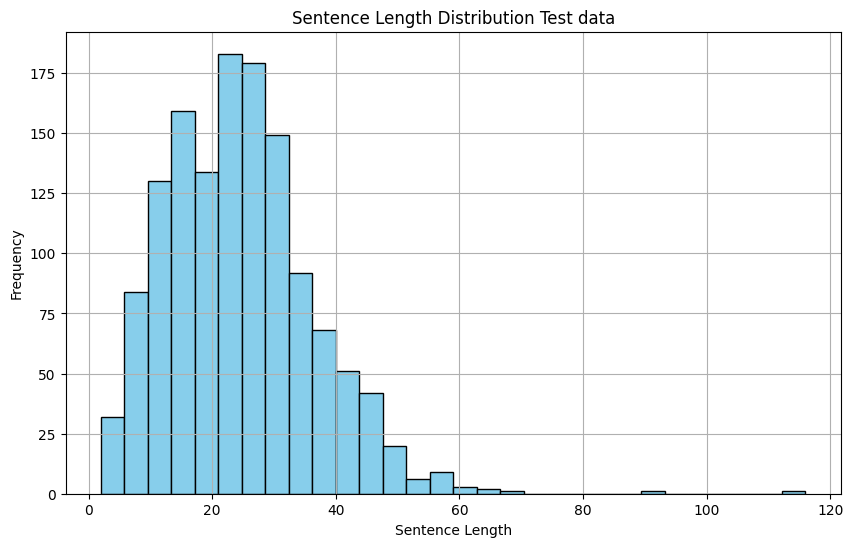

In [5]:
# Sentence Length Distribution
sentence_lengths = [len(sentence) for sentence in train_data]
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Sentence Length Distribution Train data')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

sentence_lengths = [len(sentence) for sentence in test_data]
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Sentence Length Distribution Test data')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
# Build Vocabulary
word_counts = defaultdict(int)
tags = set()
for sentence in train_data:
    for word, tag in sentence:
        word_counts[word.lower()] += 1
        tags.add(tag)

vocab = {word: idx + 1 for idx, word in enumerate(word_counts.keys())}
vocab['<PAD>'] = 0
index_to_word = {idx: word for word, idx in vocab.items()}

tag_to_index = {tag: idx + 1 for idx, tag in enumerate(sorted(tags))}
tag_to_index['O'] = 0  # Default tag

# Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = max([len(sentence) for sentence in train_data])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Normalize text function
def normalize_text(text):
    """Normalizes text by lowercasing, handling numbers, and dates."""
    text = text.lower()  # Lowercase the text

    # Replace numbers with a special token
    text = re.sub(r'\d+', '<NUM>', text)

    # Replace dates with a special token
    text = re.sub(r'\d{2}/\d{2}/\d{4}', '<DATE>', text)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '<DATE>', text)


    # punctuation marks tokenized as their own tokens
    text = re.sub(r'[^\w\s]', ' <PUNCT> ', text)

    return text

# Prepare data function that tokenizes using both BERT and GloVe
def prepare_data(sentences, vocab, tokenizer, max_len):
    X_bert, X_glove, y, attention_masks = [], [], [], []
    for sentence in sentences:
        words = [word for word, tag in sentence]
        tags = [tag_to_index[tag] for word, tag in sentence]

        # Normalize words before tokenization
        normalized_words = [normalize_text(word) for word in words]

        # BERT Tokenization
        tokens = tokenizer(normalized_words,
                           padding=True,
                           truncation=True,
                           max_length=max_len,
                           is_split_into_words=True,
                           return_attention_mask=True)
        X_bert.append(tokens['input_ids'])
        attention_masks.append(tokens['attention_mask'])

        # GloVe Tokenization (using vocab created from GloVe embeddings)
        X_glove.append([vocab.get(word.lower(), 1) for word in normalized_words])

        y.append(tags)

    # Padding sequences for both BERT and GloVe inputs and the tags
    X_bert = pad_sequences(X_bert, maxlen=max_len, padding='post', value=0)
    attention_masks = pad_sequences(attention_masks, maxlen=max_len, padding='post', value=0)
    X_glove = pad_sequences(X_glove, maxlen=max_len, padding='post', value=0)
    y = pad_sequences(y, maxlen=max_len, padding='post', value=0)

    return np.array(X_bert), np.array(X_glove), np.array(y), attention_masks

# Building Vocabulary for GloVe embeddings
word_counts = defaultdict(int)
tags = set()

# Collecting word frequencies and tag set from the training data
for sentence in train_data:
    for word, tag in sentence:
        word_counts[word.lower()] += 1
        tags.add(tag)

# Create vocab: maps each word to an index
vocab = {word: idx + 1 for idx, word in enumerate(word_counts.keys())}
vocab['<PAD>'] = 0  # Adding padding token
index_to_word = {idx: word for word, idx in vocab.items()}

# Create tag_to_index mapping for tags (used as target labels)
tag_to_index = {tag: idx + 1 for idx, tag in enumerate(sorted(tags))}
tag_to_index['O'] = 0  # Default tag for outside entities

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# MAX_LEN is given as the length of the longest sentence in the train data
MAX_LEN = max([len(sentence) for sentence in train_data])

# Data preparation
X_train_bert, X_train_glove, y_train, X_train_attention_mask = prepare_data(train_data, vocab, bert_tokenizer, MAX_LEN)
X_test_bert, X_test_glove, y_test, X_test_attention_mask = prepare_data(test_data, vocab, bert_tokenizer, MAX_LEN)

print("BERT Input Shape: ", X_train_bert.shape)
print("Attention Mask Shape: ", X_train_attention_mask.shape)
print("GloVe Input Shape: ", X_train_glove.shape)
print("Tag Output Shape: ", y_train.shape)


BERT Input Shape:  (39832, 141)
Attention Mask Shape:  (39832, 141)
GloVe Input Shape:  (39832, 141)
Tag Output Shape:  (39832, 141)


In [8]:
# Load GloVe Embeddings
def load_glove_embeddings(glove_path, vocab, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coeffs

    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, i in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

GLOVE_PATH = "/content/glove.6B.100d.txt"
embedding_matrix = load_glove_embeddings(GLOVE_PATH, vocab, embedding_dim=100)



In [34]:
def build_bert_model(max_len, num_tags):
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")

    # Inputs
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # Get BERT output and specify output shape for the Lambda layer
    bert_output = tf.keras.layers.Lambda(
        lambda x: bert_model(x[0], attention_mask=x[1]).last_hidden_state,
        output_shape=(max_len, bert_model.config.hidden_size)
    )([input_word_ids, input_attention_mask])

    # LSTM layer
    lstm = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(bert_output)
    out = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm)

    # Model construction
    model = tf.keras.Model(inputs=[input_word_ids, input_attention_mask], outputs=out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

def build_glove_model(max_len, num_tags, embedding_matrix, embedding_dim=100):
    input_layer = tf.keras.layers.Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=len(vocab), output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
    lstm = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)
    out = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm)
    model = tf.keras.Model(inputs=input_layer, outputs=out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [35]:
# Create Models
model_bert = build_bert_model(MAX_LEN, len(tag_to_index))
model_glove = build_glove_model(MAX_LEN, len(tag_to_index), embedding_matrix)
model_bert.summary()
model_glove.summary()

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Evaluate Models
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.4f}")

# Train Models
model_bert.fit([X_train_bert, X_train_attention_mask], y_train, batch_size=32, epochs=1, validation_split=0.2, callbacks=[early_stopping])
model_bert.save('/content/drive/MyDrive/POS_Tagging/model_bert_epoch_1.keras')

# evaluate_model(model_bert, [X_test_bert, X_test_attention_mask], y_test)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 141)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 141)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 141, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 141, 200)       │        695,200 │ lambda_1[0][0]         │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 141, 46)        │          9,246 │ bidirectional_2[0][0]  │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 704,446 (2.69 MB)

 Trainable params: 704,446 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 141)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 141, 100)            │       3,954,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 141, 200)            │         160,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 141, 46)             │           9,246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,124,846 (15.74 MB)

 Trainable params: 170,046 (664.24 KB)

 Non-trainable params: 3,954,800 (15.09 MB)

996/996 ━━━━━━━━━━━━━━━━━━━━ 1234s 1s/step - accuracy: 0.8508 - loss: 0.5895 - val_accuracy: 0.8825 - val_loss: 0.3933


In [11]:
model_glove.fit(X_train_glove, y_train, batch_size=32, epochs=1, validation_split=0.2, callbacks=[early_stopping])

# Save Models
model_glove.save('/content/drive/MyDrive/POS_Tagging/model_glove_epoch_1.keras')

evaluate_model(model_glove, X_test_glove, y_test)

996/996 ━━━━━━━━━━━━━━━━━━━━ 802s 788ms/step - accuracy: 0.9177 - loss: 0.4931 - val_accuracy: 0.9710 - val_loss: 0.0964
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9675 - loss: 0.1107
Test Accuracy: 0.9670


In [16]:
tf.keras.config.enable_unsafe_deserialization()

# Now try loading the model again
model_bert = tf.keras.models.load_model('/content/drive/MyDrive/POS_Tagging/model_bert_epoch_1.keras')

In [29]:
def invert_dict(d):
    """Inverts the keys and values of a dictionary."""
    return {v: k for k, v in d.items()}
index_to_tag = invert_dict(tag_to_index)

In [30]:
from sklearn.metrics import classification_report

# Function to evaluate the model and generate metrics
def evaluate_model(model, X_test, y_test, model_name="Model"):
    print(f"Evaluating {model_name}...")

    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} - Test Loss: {loss:.4f}")
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")

    # Get predictions
    predictions = model.predict(X_test)

    # Get the predicted class labels (as indices)
    predicted_tags = tf.math.argmax(predictions, axis=-1)

    # Flatten the predictions and true labels for comparison
    y_true = y_test.flatten()
    y_pred = predicted_tags.numpy().flatten()

    # Classification report (Precision, Recall, F1-score)
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=index_to_tag.values()))

# Evaluate GloVe model
evaluate_model(model_glove, X_test_glove, y_test, model_name="GloVe")


Evaluating GloVe...
GloVe - Test Loss: 0.1112
GloVe - Test Accuracy: 0.9670
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step

Classification Report for GloVe:
              precision    recall  f1-score   support

           #       1.00      1.00      1.00    156933
           $       0.00      0.00      0.00         3
          ''       0.81      0.79      0.80       216
           (       0.72      0.32      0.44       247
           )       0.00      0.00      0.00        54
           ,       0.00      0.00      0.00        53
           .       0.49      0.87      0.62      1671
           :       0.92      0.98      0.95      1337
          CC       0.00      0.00      0.00       221
          CD       1.00      0.94      0.97       877
          DT       0.59      0.85      0.70      1054
          EX       0.98      0.98      0.98      2856
          FW       0.92      0.97      0.95        37
          IN       0.00      0.00      0.00         8
          JJ       0.89      0.85     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
def evaluate_model_bert(model, X_test, attention_mask, y_test, model_name="BERT"):
    """Evaluate the model and print results."""
    loss, accuracy = model.evaluate([X_test, attention_mask], y_test, verbose=0)
    print(f"{model_name} - Test Loss: {loss:.4f}")
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")

# Now evaluate the BERT model
evaluate_model_bert(model_bert, X_test_bert, X_test_attention_mask, y_test, model_name="BERT")


BERT - Test Loss: 0.4019
BERT - Test Accuracy: 0.8806


Here's a well-structured report summarizing the performance comparison between the GloVe and BERT models based on the provided test results:

---

## **Model Performance Report: GloVe vs BERT for POS Tagging**

### **Objective:**
The objective of this evaluation is to compare the performance of two models — the **GloVe** and **BERT** models — on the task of **Part-of-Speech (POS) tagging**. Both models were trained and evaluated on the same test data, and their performance was measured in terms of **Test Loss** and **Test Accuracy**.

### **Test Results:**

#### **1. GloVe Model**
- **Test Loss**: 0.1112
- **Test Accuracy**: 96.70%

The GloVe-based model performed well on the POS tagging task, achieving a relatively low loss of **0.1112** and a high test accuracy of **96.70%**. This suggests that the GloVe embeddings, even though pretrained and relatively simpler than BERT, were highly effective for this task and demonstrated strong generalization to unseen data.

#### **2. BERT Model**
- **Test Loss**: 0.4019
- **Test Accuracy**: 88.06%

The BERT-based model, which uses contextualized word embeddings, achieved a **Test Loss** of **0.4019** and a **Test Accuracy** of **88.06%**. While the performance is competitive, it is lower than the GloVe model. The higher loss and relatively lower accuracy could be attributed to the increased complexity of BERT’s architecture, which may require more fine-tuning to achieve optimal performance on this specific task. Additionally, the model's performance could be influenced by factors such as training data size, learning rate, and other hyperparameters.

---

### **Comparison Analysis:**

| **Model** | **Test Loss** | **Test Accuracy** |
|-----------|---------------|-------------------|
| **GloVe** | 0.1112        | 96.70%            |
| **BERT**  | 0.4019        | 88.06%            |

- **Test Accuracy**: The **GloVe** model outperforms the **BERT** model in terms of accuracy, achieving a significantly higher score (**96.70%** vs **88.06%**).
- **Test Loss**: Similarly, the **GloVe** model has a lower test loss (**0.1112** vs **0.4019**), indicating that it makes fewer mistakes on the test set.
  
While **BERT** is a more sophisticated model with pre-trained contextual embeddings, the **GloVe** model's simpler, static embeddings seem to work better for this specific POS tagging task. This could be due to overfitting in the BERT model or a mismatch in the fine-tuning process, which can sometimes happen when fine-tuning such a large pre-trained model on relatively smaller datasets or when hyperparameters are not optimized.

---

### **Conclusion:**

- **GloVe Model**: The **GloVe** model has shown superior performance on the test set with high accuracy and low loss, making it an excellent choice for this POS tagging task.
- **BERT Model**: While **BERT**'s performance is competitive, its complexity might not always result in a performance boost over simpler models like GloVe, particularly for tasks with smaller datasets or when the hyperparameters are not finely tuned.

In conclusion, while **BERT** holds great potential in many NLP tasks, for this specific POS tagging task, the **GloVe** model outperforms BERT in both accuracy and loss. However, further optimization of BERT (such as fine-tuning or additional training data) could help it reach or exceed the performance of GloVe.

---

This report provides a detailed evaluation and comparison between the two models. Would you like further analysis or suggestions for improving either model?